# A rotating mesh with pulsations

In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation, add_pulsation, evaluate_pulsations
from spice.models.utils import evaluate_fourier_for_value, evaluate_many_fouriers_for_value
from spice.plots import plot_3D, plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_spectrum
import astropy.units as u
import jax
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Stromgren:b" has a newer version available.  Run phoebe.list_passband_online_history("Stromgren:b") to get a list of available changes and phoebe.update_passband("Stromgren:b") or phoebe.update_all_passbands() to update.


In [2]:
x_values = jnp.linspace(0, 2, 100)
d_0 = 1.
P = 2.
ds = jnp.array([0.75, 1.2])
phis = jnp.array([0.5, 0.4])

d_02 = 0.2
P2 = 1.
ds2 = jnp.array([1.1, 0.3])
phis2 = jnp.array([0.3, 0.3])

n = jnp.arange(1, ds.shape[0]+1)

y_values = d_0+jnp.array([jnp.sum(ds*jnp.cos(n*x/P-phis)) for x in x_values])+d_02+jnp.array([jnp.sum(ds2*jnp.cos(n*x/P2-phis2)) for x in x_values])
y_evals = jax.vmap(lambda x: jnp.sum(evaluate_many_fouriers_for_value(
    jnp.vstack([d_0, d_02]), jnp.vstack([P, P2]), jnp.vstack([ds, ds2]), jnp.vstack([phis, phis2]), x))
    )(x_values)

In [3]:
evaluate_many_fouriers_for_value(jnp.vstack([d_0, d_02]), jnp.vstack([P, P2]), jnp.vstack([ds, ds2]), jnp.vstack([phis, phis2]), 0.)

Array([[2.76346011],
       [1.53747108]], dtype=float64)

In [4]:
jnp.vstack([ds, ds2])

Array([[0.75, 1.2 ],
       [1.1 , 0.3 ]], dtype=float64)

In [5]:
jnp.hstack([jnp.array([0.1]), jnp.array([0.2])])

Array([0.1, 0.2], dtype=float64)

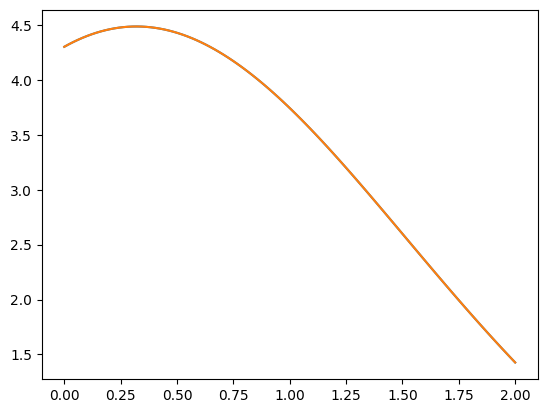

In [6]:
import matplotlib.pyplot as plt
plt.plot(x_values, y_values)
plt.plot(x_values, y_evals)

Let's use the simplest example for the sake of speed - the blackbody flux from the ```transformer_payne``` package.

In [7]:
bb = Blackbody()

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

In [8]:
base_temp = 5700
spot_1_temp = 15000
spot_2_temp = 4000

m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., bb.to_parameters(dict(teff=base_temp)))

m = add_pulsation(m, jnp.array([0, 0]), jnp.array([1., 2.]), jnp.array([[.1, .1]]))

In [9]:
mp = evaluate_pulsations(m, 1.)

In [10]:
m.vertices-mp.vertices

Array([[ 1.09903129e+10, -1.77827003e+10,  0.00000000e+00],
       [-1.09903129e+10, -1.77827003e+10,  0.00000000e+00],
       [ 1.09903129e+10,  1.77827003e+10,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],      dtype=float64)

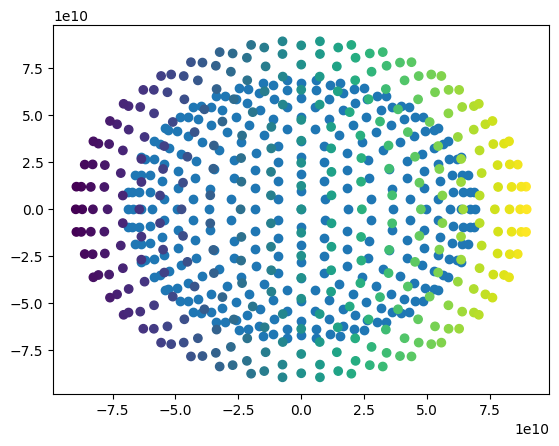

In [11]:
import matplotlib.pyplot as plt
plt.scatter(m.vertices[m.vertices[:, 2]>0, 0], m.vertices[m.vertices[:, 2]>0, 1])
plt.scatter(mp.vertices[mp.vertices[:, 2]>0, 0], mp.vertices[mp.vertices[:, 2]>0, 1], c=mp.vertices_pulsation_offsets[mp.vertices[:, 2]>0, 0])

In [12]:
mp.pulsation_velocities

Array([[  64444.32528374,  -99072.56739558,   -8414.65603882],
       [  74546.49058794,  -90317.1163495 ,  -18024.71478869],
       [  59044.30549084,  -99897.99341323,  -23946.02282206],
       ...,
       [-106189.51037906,  -52564.6173137 ,       0.        ],
       [-112191.42706182,  -36851.39562075,   -9711.30488228],
       [-110687.60318809,  -42278.90263897,       0.        ]],      dtype=float64)

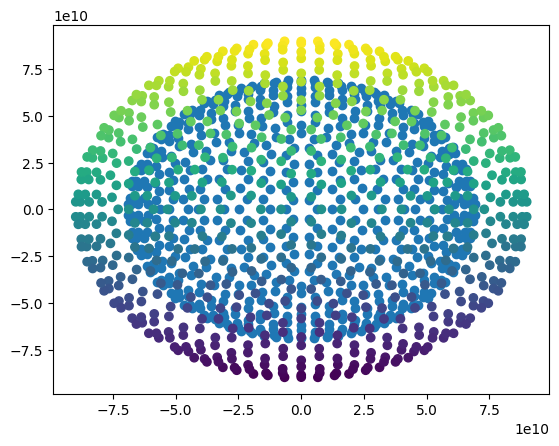

In [13]:
import matplotlib.pyplot as plt
plt.scatter(m.centers[m.centers[:, 2]>0, 0], m.centers[m.centers[:, 2]>0, 1])
plt.scatter(mp.centers[mp.centers[:, 2]>0, 0], mp.centers[mp.centers[:, 2]>0, 1], c=mp.los_velocities[mp.centers[:, 2]>0])

In [14]:
def evaluate_fourier_for_value(d0, d, p0, P, x):
    n = jnp.arange(1, d.shape[0]+1)
    return d0 + jnp.sum(d*jnp.cos(n/P*x-p0))

In [15]:
def _create_harmonics_params(n_max: int):
    n = int(jnp.sqrt(n_max))
    x, y = jnp.meshgrid(jnp.arange(0, n), jnp.arange(0, n))
    return jnp.vstack([x.ravel(), y.ravel()]).T

In [16]:
_create_harmonics_params(10)

Array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [0, 2],
       [1, 2],
       [2, 2]], dtype=int64)

In [43]:
TIMESTAMPS = jnp.linspace(0, 2., 5)

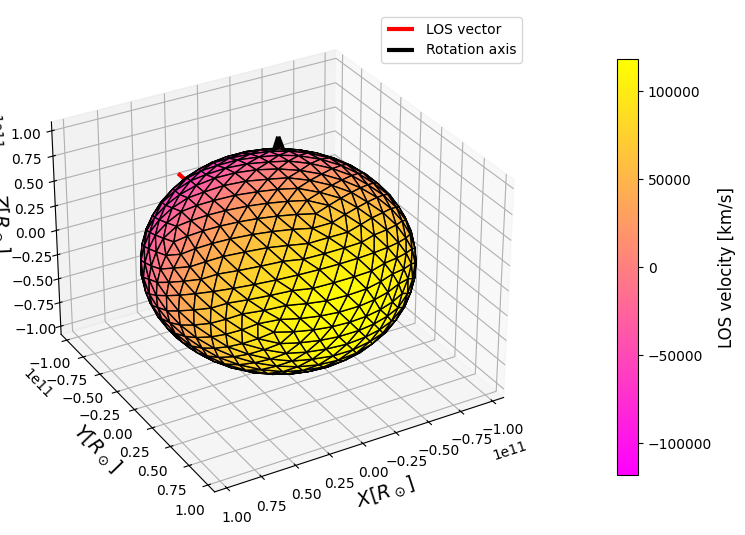

In [44]:
_, _ = plot_3D(mp, 'los_velocities', cmap='spring')

In [45]:
from spice.plots import plot_3D_sequence
mps = [evaluate_pulsations(m, t) for t in jnp.linspace(0, 2., 5)]

/Users/majajablonska/Documents/Workspace/stellar-mesh-integration/src/spice/plots/plot_mesh.py:273: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


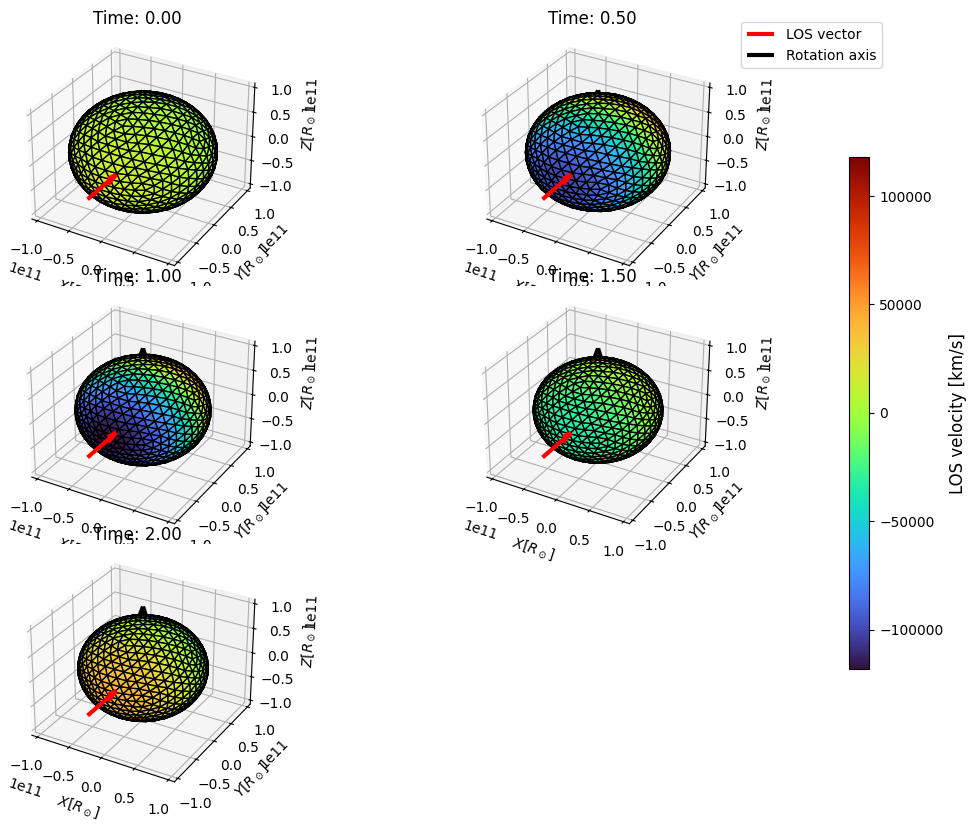

In [46]:
_, _, _ = plot_3D_sequence(mps, 'los_velocities', jnp.linspace(0, 2., 5))

## Spectrum emulation

In [31]:
vws = jnp.linspace(100., 12000., 1000)
specs = [simulate_spectrum(bb.intensity, mp0, jnp.log10(vws)) for mp0 in mps]

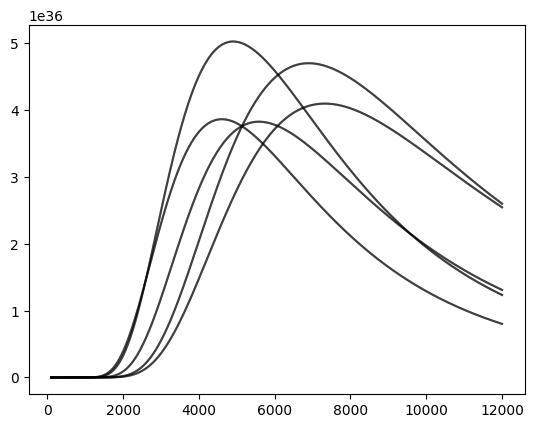

In [32]:
import matplotlib.pyplot as plt

for spec in specs:
    plt.plot(vws, spec, color='black', alpha=0.5)

(<Figure size 2400x1000 with 3 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>,
 <Axes: xlabel='wavelength [$\\AA$]', ylabel='intensity [erg/s/cm$^2$]'>)

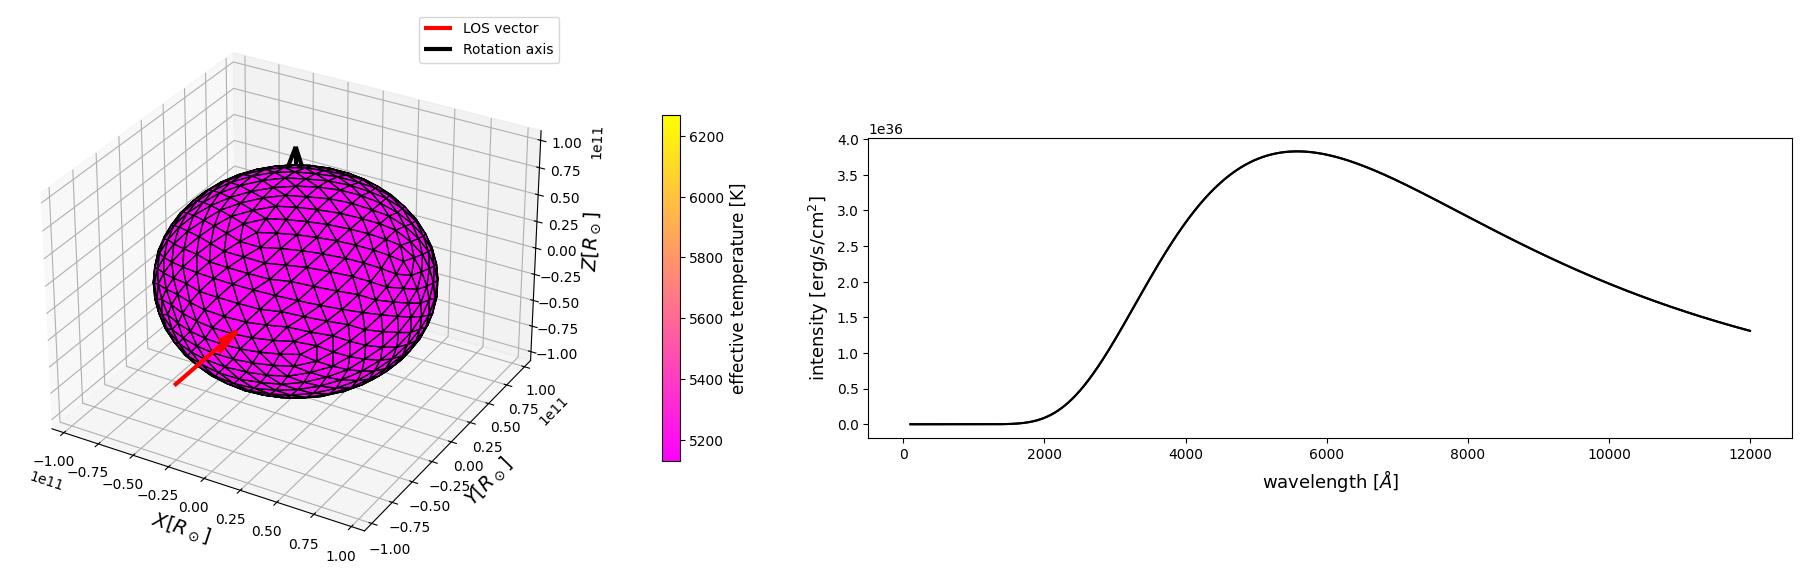

In [35]:
time_idx = 3
plot_3D_mesh_and_spectrum(mps[time_idx], vws, specs[time_idx], dict(property=0, cmap='spring', property_label='effective temperature [K]'))

(<Figure size 2400x1000 with 3 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>,
 <Axes: xlabel='wavelength [$\\AA$]', ylabel='intensity [erg/s/cm$^2$]'>)

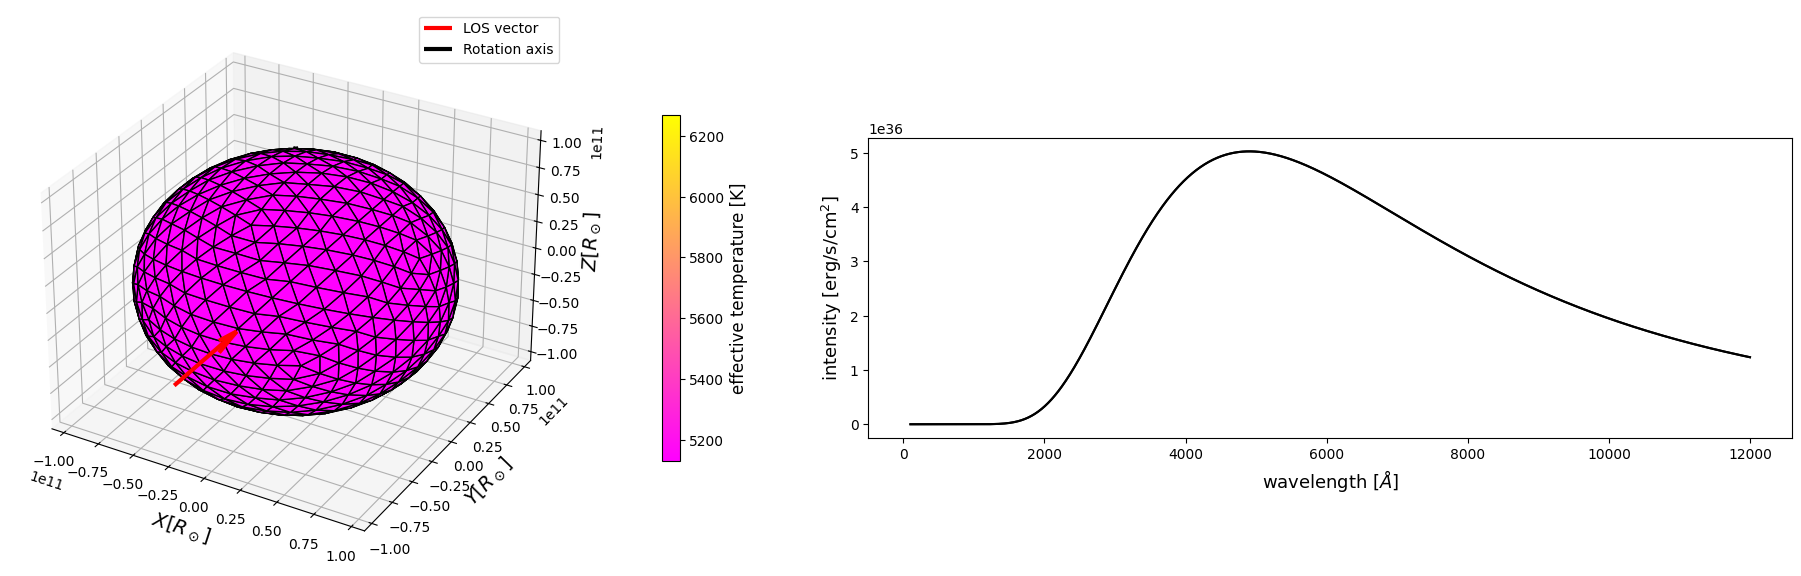

In [36]:
time_idx = 0
plot_3D_mesh_and_spectrum(mps[time_idx], vws, specs[time_idx], dict(property=0, cmap='spring', property_label='effective temperature [K]'))

## Photometric time series

In [37]:
from spice.spectrum.filter import BesselU, BesselB, BesselV
from spice.spectrum.spectrum import AB_passband_luminosity

In [38]:
bessel_B = BesselB()
bessel_U = BesselU()
bessel_V = BesselV()

In [40]:
d = u.AU.to(u.cm)
U_phot = np.array([AB_passband_luminosity(bessel_U, vws, flux[:, 0], distance=d) for flux in specs])
B_phot = np.array([AB_passband_luminosity(bessel_B, vws, flux[:, 0], distance=d) for flux in specs])
V_phot = np.array([AB_passband_luminosity(bessel_V, vws, flux[:, 0], distance=d) for flux in specs])

# Calculate color indices
U_B = U_phot - B_phot
B_V = B_phot - V_phot


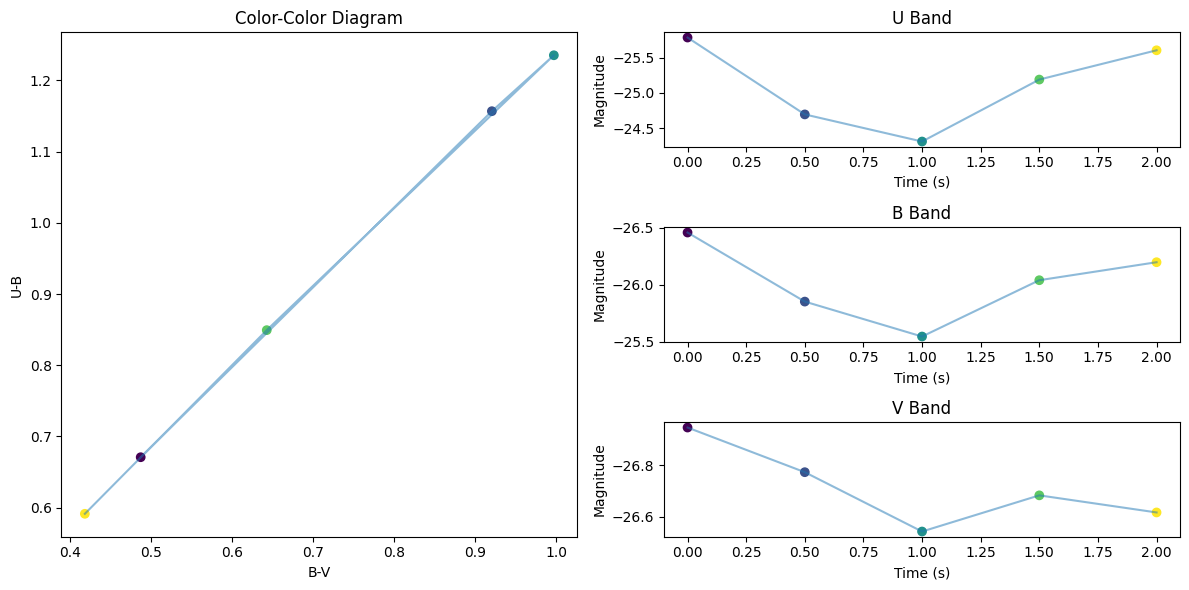

In [47]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Plot color-color diagram
ax_color = fig.add_subplot(gs[:, 0])
ax_color.plot(B_V, U_B, alpha=0.5)
ax_color.scatter(B_V, U_B, c=TIMESTAMPS, cmap='viridis')
ax_color.set_xlabel('B-V')
ax_color.set_ylabel('U-B')
ax_color.set_title('Color-Color Diagram')

# Photometry data and labels for loop
phot_data = [U_phot, B_phot, V_phot]
labels = ['U Band', 'B Band', 'V Band']

# Create photometry magnitude time series plots
for i, (data, label) in enumerate(zip(phot_data, labels)):
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(TIMESTAMPS, data, label=label, alpha=0.5)
    ax.scatter(TIMESTAMPS, data, c=TIMESTAMPS, cmap='viridis', label='Markers')

    ax.set_title(label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Magnitude')
    ax.invert_yaxis()

plt.tight_layout()